# Milestone 2: Data wrangling and initial analyses

## 0. Imports

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
from wordcloud import WordCloud, STOPWORDS
import gzip
from pylab import xticks
import tqdm.notebook 
from tqdm.notebook import trange
import pickle
import warnings
warnings.filterwarnings("ignore")

## 1.  Familiarization with CMU Movie Summary Corpus dataset and restructuration

In this section, we familiarize ourselves with the CMU Movie Summary Corpus dataset. We also restructure the data to make it directly usable for our future analysis.

### 1.1 Character metadata

In [2]:
#Importing character metadata
df_char_meta = pd.read_table("./data/MovieSummaries/character.metadata.tsv", header=None)
df_char_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "character name", "Actor date of birth", "Actor gender", 
            "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", 
            "Freebase character ID", "Freebase actor ID"]

In [3]:
df_char_meta.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
320199,7193670,/m/0kv02n,1960-08-11,Franz Liszt,1921-03-28,M,1.74,NaN,Dirk Bogarde,39.0,/m/02vcrg3,/m/075hxfy,/m/0151xv
61475,19347806,/m/04mylbf,1929-10-12,NaN,1923-01-14,F,NaN,NaN,Mary Ann Jackson,6.0,/m/052f82g,NaN,/m/04k4kn
209587,6738531,/m/0glk60,2001-09-21,Vikram Bajaj ((Vicky),1967-09-09,M,1.85,/m/0dryh9k,Akshay Kumar,34.0,/m/02tb5kj,/m/0gxr9mz,/m/02tq2r
404365,29769606,/m/0fp_dsj,2012-11-21,Lord Kira,1973-11-27,M,1.79,NaN,Tadanobu Asano,38.0,/m/0gwk9ff,/m/0gwk9fj,/m/01nc8c
423386,2041686,/m/06h1pt,1977,NaN,NaN,NaN,NaN,NaN,Sonny Buddy Jr,NaN,/m/0gcg9sx,NaN,/m/0gcf77y


In [4]:
print("Total size of the dataset: " + str(df_char_meta.shape[0]))

Total size of the dataset: 450669


In [5]:
print("Number of entries for which we don't have the gender: " + str(df_char_meta["Actor gender"].isnull().values.sum()))


Number of entries for which we don't have the gender: 45609


In [6]:
print("Number of entries for which we don't have the age at the movie release date: " + 
      str(df_char_meta["Actor age at movie release"].isnull().values.sum()))

Number of entries for which we don't have the age at the movie release date: 158113


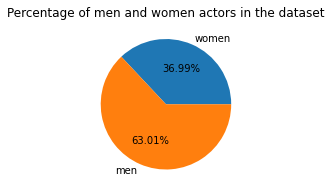

In [7]:
mylabels = ["women", "men"]
plt.figure(figsize=(3,3)) 
plt.pie(np.array([df_char_meta[df_char_meta['Actor gender'] == 'F']['Actor name'].nunique(),df_char_meta[df_char_meta['Actor gender'] == 'M']['Actor name'].nunique()]), labels = mylabels, autopct='%1.2f%%')
plt.title("Percentage of men and women actors in the dataset")
plt.show()

### 1.2 Movie metadata

In [8]:
#Importing the data
df_movie_meta = pd.read_table("./data/MovieSummaries/movie.metadata.tsv", header=None)
df_movie_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", 
                     "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]


In [9]:
#Creating lists in desired columns
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: list(x.values()))
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: list(x.values()))
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: list(x.values()))

In [10]:
#Keeping only the year of the movie
df_movie_meta.query("`Movie release date` > '1915'", inplace = True)
df_movie_meta["Movie release date"] = pd.to_datetime(df_movie_meta["Movie release date"])
df_movie_meta["Movie release date"] = df_movie_meta["Movie release date"].dt.year

In [11]:
df_movie_meta.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
80544,35376659,/m/0j9mntz,Hamateur Night,1939,NaN,8.0,[English Language],[United States of America],"[Short Film, Family Film, Comedy film, Animation]"
46337,16228326,/m/03wdhqq,Le Matou,1985,NaN,141.0,[French Language],"[France, Canada]",[Drama]
69752,13836834,/m/03cktf7,Dead Boyz Don't Scream,2006,NaN,85.0,[English Language],[United States of America],"[LGBT, Slasher]"
66498,25446184,/m/09k6fgl,Mosagadu,1980,NaN,NaN,[Telugu language],[India],"[Family Film, Action, Drama]"
21993,27876280,/m/0cc9_tp,To Take a Wife,2004,NaN,97.0,"[French Language, Arabic Language, Hebrew Lang...","[France, Israel]",[Drama]


Text(0.5, 1.0, 'Number of movies released each year')

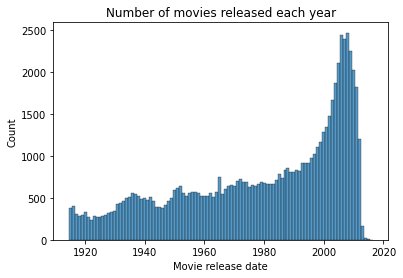

In [12]:
sns.histplot(df_movie_meta['Movie release date'], discrete = True)
plt.title('Number of movies released each year')

We see that the number of movies available in the dataset increase slowly between the 1920s and then 1990s increases exponentially starting 1990.

Text(0.5, 1.0, 'Top movie coutries')

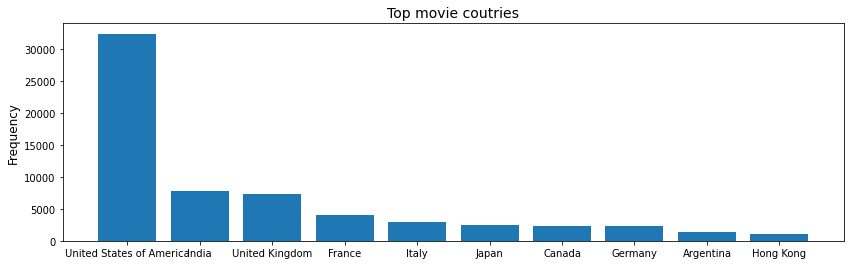

In [13]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
a = to_1D(df_movie_meta['Movie countries']).value_counts().nlargest(10)

fig, ax = plt.subplots(figsize = (14,4))
ax.bar(a.index,
        a.values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top movie coutries", size = 14)

Text(0.5, 1.0, 'Top genres')

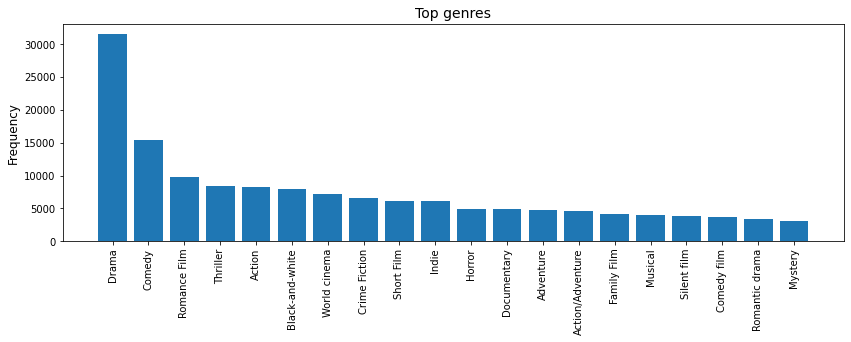

In [14]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

a = to_1D(df_movie_meta['Movie genres']).value_counts().nlargest(20)

fig, ax = plt.subplots(figsize = (14,4))
ax.bar(a.index,
        a.values)
plt.xticks(rotation=90)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top genres", size = 14)

### Merging and cleaning the two datasets

In [15]:
df_merged_meta = pd.DataFrame(df_char_meta[["Freebase movie ID", "Actor gender", "Actor age at movie release"]])
df_merged_meta = pd.merge(df_merged_meta, df_movie_meta[["Freebase movie ID", "Movie release date", 
                                                        "Movie countries", "Movie genres"]], on="Freebase movie ID")

In [16]:
df_merged_meta.sample(5)

,Freebase movie ID,Actor gender,Actor age at movie release,Movie release date,Movie countries,Movie genres
39228,/m/05c1h76,F,22.0,2009,[Philippines],"[Romantic comedy, World cinema, Filipino Movie..."
156204,/m/09k7kv2,M,45.0,1999,[],[]
437468,/m/0hgqt1w,M,48.0,1961,[],"[Biographical film, Action, Drama]"
55118,/m/09rmm4w,M,32.0,1937,[United States of America],"[Romance Film, Comedy]"
217814,/m/0crvlhb,F,NaN,1954,[Mexico],"[Action/Adventure, Thriller, Drama, Adventure,..."


In [17]:
print("Size of the gloabal dataset: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor gender'], inplace = True)
print("Size after removing entries with no gender: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor age at movie release'], inplace = True)
print("Size after removing entries with no age at movie release: " + str(df_merged_meta.shape[0]))

Size of the gloabal dataset: 437830
Size after removing entries with no gender: 392446
Size after removing entries with no age at movie release: 290726


### 1.3 Plot summaries

### 1.4 Core NLP plot summaries

## 2. Familiarization with IMDb dataset and restructuration

In [18]:
data_folder_IMDB = './IMDb data/'

In this section, we familiarize ourselves with the IMDb dataset. We select the useful data for our future analysis.

### 2.1 Titles principals

In [19]:
f = gzip.open(data_folder_IMDB + './title.principals.tsv.gz','rb')
df_titles_principal = pd.read_csv(f, sep='\t')
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [20]:
df_titles_principal['category'].unique()

array(['self', 'director', 'cinematographer', 'composer', 'producer',
       'editor', 'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

We see that IMDb dataset differentiates actresses from actors, but does not for the other jobs. We are interested genders of actors, writers, producers, directors, so we query them using SQL.

SELECT 
  ?id
  ?gender
  ?IMDb_ID 

WHERE 
{
  ?id p:P345 ?id2.
  ?id wdt:P21 ?gender. 
  ?id wdt:P345 ?IMDb_ID.
}

In [21]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
gender_imdb.head(5)

,gender,IMDb_ID
0,Q6581097,nm0899581
1,Q6581097,nm2561320
2,Q6581097,nm0005240
3,Q6581097,nm0707199
4,Q6581097,nm1211443


Now we replace wikidata ids by the gender (male = Q6581097 and female = Q6581072). Category "actress" gets gender female and category "actor" gets gender male. We discard trangender people, two-spirit, genderqueer, bigender people and all very singular genre attributes because of their rarity.

In [22]:
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [23]:
gender_imdb.head(5)

,gender,IMDb_ID
0,male,nm0899581
1,male,nm2561320
2,male,nm0005240
3,male,nm0707199
4,male,nm1211443


In [24]:
gender_imdb['gender'].value_counts()

male      280097
female    146461
Name: gender, dtype: int64

Now let's merge the two dataframes based on the IMDb id.

In [25]:
df_titles_principal = df_titles_principal.merge(gender_imdb, how= 'left', left_on = 'nconst', right_on = 'IMDb_ID')

In [26]:
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
4,tt0000002,2,nm1335271,composer,\N,\N,NaN,NaN


We add the information coming from actress/actor to the gender column :

In [27]:
df_titles_principal.gender.fillna(df_titles_principal.category, inplace=True)
df_titles_principal['gender'] = df_titles_principal['gender'].str.replace('actress', 'female')
df_titles_principal['gender'] = df_titles_principal['gender'].str.replace('actor', 'male')
df_titles_principal = df_titles_principal[df_titles_principal['gender'].str.contains('male|female')]

In [28]:
df_titles_principal = df_titles_principal.drop_duplicates()
df_titles_principal

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
5,tt0000003,1,nm0721526,director,\N,\N,male,nm0721526
...,...,...,...,...,...,...,...,...
53108099,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",male,nm1483166
53108100,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]",female,NaN
53108101,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]",male,nm0286175
53108102,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]",female,nm10535738


In [29]:
#creates a file
picklefile = open('df_titles_principal_with_gender', 'wb')
#pickles the dataframe
pickle.dump(df_titles_principal, picklefile)

### 2.2 Name basics

From this file, we keep the birth year and the primary name and merge with the previous dataset.

In [30]:
picklefile = open('df_titles_principal_with_gender', 'rb')
#unpickle the dataframe
df_titles_principal = pickle.load(picklefile)
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
5,tt0000003,1,nm0721526,director,\N,\N,male,nm0721526


In [31]:
f=gzip.open(data_folder_IMDB + './name.basics.tsv.gz','rb')
df_name_basics = pd.read_csv(f, sep='\t')
df_name_basics.head(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0050419,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0083922"


In [32]:
df_name_basics_short = df_name_basics.drop(columns = ['primaryProfession', 'knownForTitles', 'deathYear'])
df_name_basics_short

,nconst,primaryName,birthYear
0,nm0000001,Fred Astaire,1899
1,nm0000002,Lauren Bacall,1924
2,nm0000003,Brigitte Bardot,1934
3,nm0000004,John Belushi,1949
4,nm0000005,Ingmar Bergman,1918
...,...,...,...
12066988,nm9993714,Romeo del Rosario,\N
12066989,nm9993716,Essias Loberg,\N
12066990,nm9993717,Harikrishnan Rajan,\N
12066991,nm9993718,Aayush Nair,\N


In [33]:
df_titles_principal = df_titles_principal.merge(df_name_basics_short, how='left', on = 'nconst')
df_titles_principal = df_titles_principal.drop(columns = 'IMDb_ID')
df_titles_principal

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,Carmencita,1868
1,tt0000001,2,nm0005690,director,\N,\N,male,William K.L. Dickson,1860
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,William Heise,1847
3,tt0000002,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844
4,tt0000003,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844
...,...,...,...,...,...,...,...,...,...
32111041,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",male,Aidan Cook,\N
32111042,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]",female,Sue Elliott-Nichols,\N
32111043,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]",male,Wayne Forester,\N
32111044,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]",female,Eden Gamliel,1995


### 2.3 Title crew

This data allows us to know the directors and writers for each movie.

In [34]:
f = gzip.open(data_folder_IMDB + '/title.crew.tsv.gz', 'rb')
df_title_crew=  pd.read_csv(f, sep='\t')
df_title_crew.head(10)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
5,tt0000006,nm0005690,\N
6,tt0000007,"nm0005690,nm0374658",\N
7,tt0000008,nm0005690,\N
8,tt0000009,nm0085156,nm0085156
9,tt0000010,nm0525910,\N


In [35]:
df23 = df_titles_principal.merge(df_title_crew, how='left', on = 'tconst')
df23.head(5)

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,directors,writers
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,Carmencita,1868,nm0005690,\N
1,tt0000001,2,nm0005690,director,\N,\N,male,William K.L. Dickson,1860,nm0005690,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,William Heise,1847,nm0005690,\N
3,tt0000002,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844,nm0721526,\N
4,tt0000003,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844,nm0721526,\N


We now merge the crew (writer and director) data with the genders

### 2.4 Title basics

In [36]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
df_title_basics.head(5)

C:\Users\33642\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [37]:
print("There are {} titles in the IMDb dataset".format(len(df_title_basics)))

There are 9363390 titles in the IMDb dataset


That is definitely a lot of titles. But not all of them are movies. Let's check what part of the dataset contains movies

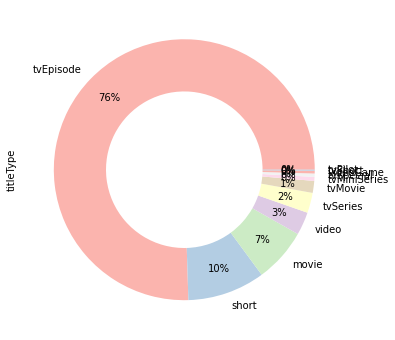

In [38]:
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
df_title_basics.titleType.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4), colors = colors)
plt.show()

Only 7% of the dataset are movies. Let's isolate them.

In [39]:
df_movie_basics = df_title_basics[df_title_basics['titleType'] == 'movie']
print("There are {} movies in the IMDb dataset".format(len(df_movie_basics)))
df_movie_basics = df_movie_basics.drop(columns = ['titleType', 'isAdult', 'endYear'])
df_movie_basics.head(5)

There are 626772 movies in the IMDb dataset


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
498,tt0000502,Bohemios,Bohemios,1905,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama
610,tt0000615,Robbery Under Arms,Robbery Under Arms,1907,\N,Drama


In [40]:
df24 = df_titles_principal.merge(df_movie_basics, how = 'inner', on = 'tconst')
df24

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N


In [41]:
#creates a file
picklefile = open('df24', 'wb')
#pickles the dataframe
pickle.dump(df24, picklefile)

In [42]:
picklefile = open('df24', 'rb')
#unpickle the dataframe
df24_retrieved = pickle.load(picklefile)
df24_retrieved

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N


### 2.5 Title ratings

In [43]:
f = gzip.open(data_folder_IMDB + '/title.ratings.tsv.gz', 'rb')
df_title_ratings=  pd.read_csv(f, sep='\t')
df_title_ratings.head(5)

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


In [44]:
df_25 = df24_retrieved.merge(df_title_ratings, how = 'left', on = 'tconst')

In [45]:
#creates a file
picklefile = open('df_25', 'wb')
#pickles the dataframe
pickle.dump(df_25, picklefile)

### 2.6 Linking IMDb Ids to freebase movie Ids

In [46]:
picklefile = open('df_25', 'rb')
#unpickle the dataframe
df25_retrieved = pickle.load(picklefile)
df25_retrieved

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N,4.2,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy,NaN,NaN
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0


In [47]:
df25_retrieved.rename(columns ={'gender' : 'gender nconst'})

,tconst,ordering,nconst,category,job,characters,gender nconst,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N,4.2,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy,NaN,NaN
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0


We query the mapping between freebase and IMDb IDs on movies

In [48]:
freebase_to_imdb = pd.read_csv('freebase_to_imdb.csv')
freebase_to_imdb.drop(columns = ['sitelink', 'item'], inplace = True)
freebase_to_imdb

,freebaseID,IMDb_ID
0,/m/05cj_j,tt0074512
1,/m/0d1t3h,tt0079630
2,/m/0gt35,tt0031971
3,/m/0hhpxh5,tt2115388
4,/m/0gw4m1,tt0465676
...,...,...
102803,/m/011rzh4s,tt3307774
102804,/m/0_yvpsd,tt2119383
102805,/m/0gm160t,tt1117379
102806,/m/0jkwsv6,tt2099556


We obtained 102808 matches between freebase IDs and IMDb IDs.

In [49]:
df26 = df25_retrieved.merge(freebase_to_imdb, how = 'inner', left_on = 'tconst', right_on = 'IMDb_ID')
df26 = df26.drop(columns ='IMDb_ID')
df26 = df26.drop_duplicates()
final_df_imdb = df26

In [50]:
print('We kept {} movies and {} persons working on those movies'.format(final_df_imdb['tconst'].nunique(),final_df_imdb['nconst'].nunique()))

We kept 95116 movies and 182266 persons working on those movies


In [51]:
final_df_imdb.describe()

,ordering,averageRating,numVotes
count,732778.000000,662971.000000,6.629710e+05
mean,4.878602,6.167301,1.066603e+04
std,2.819658,1.087002,6.368150e+04
min,1.000000,1.000000,5.000000e+00
25%,2.000000,5.600000,8.400000e+01
50%,4.000000,6.300000,3.670000e+02
75%,7.000000,6.900000,1.798000e+03
max,10.000000,9.800000,2.659398e+06


In [52]:
final_df_imdb = final_df_imdb.merge(df_title_crew, how = 'left', on = 'tconst')

In [53]:
#creates a file
picklefile = open('final_df_imdb', 'wb')
#pickles the dataframe
pickle.dump(final_df_imdb, picklefile)

In [54]:
final_df_imdb

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,freebaseID,directors,writers
0,tt0000591,1,nm0906197,actor,\N,\N,male,Georges Wague,1874,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
1,tt0000591,2,nm0332182,actor,\N,\N,male,Henri Gouget,\N,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
2,tt0000591,3,nm1323543,actress,\N,\N,female,Christiane Mandelys,1873,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
3,tt0000591,4,nm1759558,actress,\N,\N,female,Gilberte Sergy,\N,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
4,tt0000591,5,nm0141150,director,\N,\N,male,Michel Carré,1865,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732773,tt9898504,4,nm0474753,actress,\N,\N,female,Noor Kumalasari,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N
732774,tt9898504,6,nm1007470,actor,\N,\N,male,Puteh Lawak,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N
732775,tt9898504,7,nm0575397,actor,\N,"[""Datuk Bendahara""]",male,Shariff Medan,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N
732776,tt9898504,8,nm1403057,actor,\N,"[""Ayahanda Tengku Zainol""]",male,Ahmad Nisfu,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N


At the end of this pipeline, we have a notebook with for 95 116 movies matching freebase ids, the principal cast, their genders which have been queried, and some more information on the movie they play in. We also have shown the utility of the IMDb dataset to get access to the director and writer for which we can obtain genders which can be add a lot to the analysis. We can see if having a movie written by a man or a woman in order reinforce certain characters stereotypes. Furthermore, we will show in the initial analyses that we can use the cinemagoer library to access a breakdown of movie reviews by gender and by age.

# 3. Initial analysis

### 3.1 Description of characters in the summaries

### 3.2 Are women younger in cinema ?

#### 3.2.1 Evolution through time

#### 3.2.2 Differences between genres

### 3.3 Difference in importance of movie roles women and men get

### 4.4 Are IMDb ratings representing somewhat more male or female opinion on movie ? 

We show here that we can access the breakdown of movie ratings by gender, which can be useful to the analysis. Indeed, we look at how genders are represented in cinema, and seeing how their opinion is represented on a popular website like IMDb can be an interesting persepective. We study quickly the top 250 movies as an initial analysis.

In [56]:
from imdb import IMDb
ia = IMDb()

In [57]:
top250 = ia.get_top250_movies()

df = pd.DataFrame()
ids = []
# Iterate through the first 20 movies in the top 250
for movie_count in range(0, 250):
    # First, retrieve the movie object using its ID
    movie = ia.get_movie(top250[movie_count].movieID, 'vote details')
    a = pd.DataFrame.from_dict(movie.get('demographics'))
    movie = ia.get_movie(top250[movie_count].movieID) # The identifier is simply tconst without "tt"
    ids.append(str(movie.get('title')) + " votes")
    ids.append(str(movie.get('title')) + " ratings")
    
    df = df.append(a)

250


Text(0, 0.5, 'Number of movies')

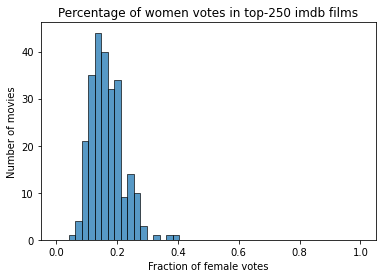

In [60]:
df = df.set_index(np.array(ids))
df_votes = df[df['ttrt fltr imdb users']>10]
print(len(df_votes))
df_votes['percent_women'] = df_votes['ttrt fltr females']/( df_votes['ttrt fltr males'] +  df_votes['ttrt fltr females'])

sns.histplot(df_votes['percent_women'], binrange = (0,1))
plt.title('Percentage of women votes in top-250 imdb films')
plt.xlabel('Fraction of female votes')
plt.ylabel('Number of movies')

In [64]:
df_votes.describe()

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users,percent_women
count,2.500000e+02,250.000000,250.000000,2.500000e+02,250.000000,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,2.500000e+02,250.000000
mean,6.352786e+05,277.176000,83823.344000,2.550466e+05,74302.516000,3.635361e+05,202.160000,65041.704000,210050.644000,61605.228000,74068.936000,52.976000,16110.156000,41201.576000,11254.284000,715.41200,144254.120000,4.163520e+05,0.166873
std,5.133889e+05,284.388347,73289.462886,2.063204e+05,52377.664702,2.890784e+05,206.923124,56654.744561,170153.857151,43570.407142,62073.573174,52.407189,15142.393314,35377.014454,8077.858579,156.81968,114511.149846,3.330819e+05,0.053247
min,3.006200e+04,13.000000,2231.000000,1.240700e+04,1617.000000,2.061600e+04,6.000000,1986.000000,11212.000000,1451.000000,1711.000000,5.000000,208.000000,679.000000,129.000000,108.00000,5674.000000,2.173100e+04,0.042903
25%,2.214612e+05,77.000000,25061.000000,8.541875e+04,31942.000000,1.215315e+05,54.000000,18652.000000,67796.000000,26551.500000,22810.250000,17.000000,3780.000000,11864.750000,4846.250000,626.25000,47930.250000,1.432362e+05,0.128917
50%,4.906855e+05,164.000000,64072.500000,1.849370e+05,64661.500000,2.788960e+05,122.500000,50688.000000,155002.000000,53793.000000,57989.500000,33.000000,10835.500000,32323.500000,9518.500000,746.00000,119063.000000,3.287995e+05,0.161445
75%,9.541290e+05,398.750000,126606.250000,3.757270e+05,104674.000000,5.337772e+05,295.750000,94534.250000,313899.000000,87291.250000,113953.750000,66.750000,25193.500000,64804.250000,15973.000000,841.50000,212160.500000,6.147062e+05,0.196589
max,2.661901e+06,1689.000000,374585.000000,1.060802e+06,273937.000000,1.490175e+06,1158.000000,300628.000000,886560.000000,221704.000000,295931.000000,350.000000,76429.000000,165998.000000,45994.000000,931.00000,619745.000000,1.669361e+06,0.394324


Women contributes to only 16.9% of the ratings in the top IMDb movies. Not a single of these movies have more ratings coming from women. The opinion represented on IMDb is mainly male opinion at least for the top rated movies.